In [12]:
# import lib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [13]:
import pandas as pd 

df = pd.read_csv('D:/project_data_mining/src/dataset.csv')

In [14]:
# # split train/val/test 
# train_df = df[(df["TIME_PERIOD"] >= "2011-01-01") & (df["TIME_PERIOD"] <= "2020-12-31")]
# val_df   = df[(df["TIME_PERIOD"] >= "2021-01-01") & (df["TIME_PERIOD"] <= "2022-12-31")]
# test_df  = df[(df["TIME_PERIOD"] >= "2023-01-01") & (df["TIME_PERIOD"] <= "2025-12-31")]

In [15]:
def split_by_time_cat(df_cat):
    train = df_cat[df_cat["YEAR"] <= 2020]
    val   = df_cat[(df_cat["YEAR"] >= 2021) & (df_cat["YEAR"] <= 2022)]
    test  = df_cat[df_cat["YEAR"] >= 2025]
    return train, val, test


In [16]:
# metric
from sklearn.metrics import mean_absolute_error, mean_squared_error

def smape(y_true, y_pred):
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) /
        (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    )

def pred_10(y_true, y_pred):
    return np.mean(
        np.abs(y_pred - y_true) / (np.abs(y_true) + 1e-8) < 0.1
    ) * 100

def evaluate(y_true, y_pred):
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "sMAPE": smape(y_true, y_pred),
        "Pred10": pred_10(y_true, y_pred)
    }



In [17]:
# train SARIMAx 1 category 
from statsmodels.tsa.statespace.sarimax import SARIMAX

def sarimax_one_category(df_cat, order=(1,1,1), seasonal_order=(0,1,1,12)):
    train, val, test = split_by_time_cat(df_cat)

    y_train = train["CPI"]
    exog_train = train[["Energy", "GDP"]]

    y_test = test["CPI"]
    exog_test = test[["Energy", "GDP"]]

    model = SARIMAX(
        y_train,
        exog=exog_train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    res = model.fit(disp=False)

    y_pred = res.forecast(
        steps=len(test),
        exog=exog_test
    )

    result = test[["TIME_PERIOD", "Expenditure_category"]].copy()
    result["CPI_actual"] = y_test.values
    result["CPI_pred_ARIMA"] = y_pred.values

    metrics = evaluate(y_test.values, y_pred.values)

    return result, metrics



In [18]:
#  train all category 
all_results = []
all_metrics = []

for cat in df["Expenditure_category"].unique():
    df_cat = df[df["Expenditure_category"] == cat].copy()

    # safety check
    if len(df_cat) < 60:
        print(f"Skip {cat} (too short)")
        continue

    result_cat, metrics_cat = sarimax_one_category(df_cat)

    all_results.append(result_cat)
    all_metrics.append({
        "Category": cat,
        **metrics_cat
    })




d:\project_data_mining\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\project_data_mining\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\project_data_mining\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\project_data_mining\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model w

In [19]:
# gộp 
forecast_df = pd.concat(all_results, ignore_index=True)
forecast_df.tail()


,TIME_PERIOD,Expenditure_category,CPI_actual,CPI_pred_ARIMA
115,2025-06-01,Transport,101.602,72.522008
116,2025-07-01,Transport,101.822,72.842783
117,2025-08-01,Transport,102.053,73.296114
118,2025-09-01,Transport,103.679,73.391845
119,2025-10-01,Transport,104.846,73.495183


In [20]:
# results
metrics_df = pd.DataFrame(all_metrics)
metrics_df



,Category,RMSE,MAE,sMAPE,Pred10
0,All Items,13.369778,13.365441,14.209095,0.0
1,Clothing and footwear,3.955965,3.880956,3.813289,100.0
2,Communication,0.829903,0.687146,0.698574,100.0
3,Education,0.174922,0.133278,0.132097,100.0
4,Food and non-alcoholic beverages,11.690207,11.681610,12.276398,0.0
5,"Furnishings, household equipment and routine h...",4.026731,3.997254,4.093729,100.0
6,Health,11.722074,11.701251,12.135360,0.0
7,"Housing, water, electricity, gas and other fuels",14.222573,14.209065,15.207254,0.0
8,Miscellaneous goods and services,2.715724,2.693051,2.735410,100.0
9,Recreation and culture,12.345497,12.314103,13.323125,0.0


In [21]:
y_true_all = forecast_df["CPI_actual"].values
y_pred_all = forecast_df["CPI_pred_ARIMA"].values


def pred_k(y_true, y_pred, k=0.15):
    return np.mean(
        np.abs(y_pred - y_true) / (np.abs(y_true) + 1e-8) < k
    ) * 100

overall_metrics = {
    "RMSE": float(np.sqrt(mean_squared_error(y_true_all, y_pred_all))),
    "MAE": mean_absolute_error(y_true_all, y_pred_all),
    "sMAPE(%)": float(smape(y_true_all, y_pred_all)),
    "Pred10(%)": float(pred_k(y_true_all, y_pred_all, 0.1))
}

overall_metrics


{'RMSE': 12.68267288799028,
 'MAE': 9.908132969476737,
 'sMAPE(%)': 10.667768471308598,
 'Pred10(%)': 41.66666666666667}

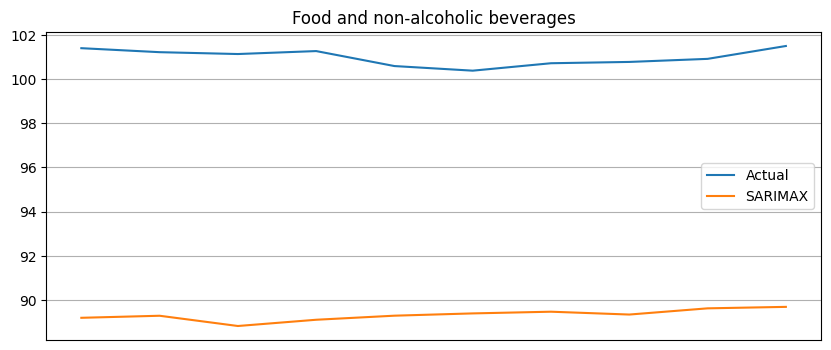

In [22]:
# vẽ biểu đồ 1 category
def plot_category(cat):
    df_plot = forecast_df[forecast_df["Expenditure_category"] == cat]

    plt.figure(figsize=(10,4))
    plt.plot(df_plot["TIME_PERIOD"], df_plot["CPI_actual"], label="Actual")
    plt.plot(df_plot["TIME_PERIOD"], df_plot["CPI_pred_ARIMA"], label="SARIMAX")
    plt.title(cat)
    plt.xticks([])
    plt.legend()
    plt.grid(True)
    plt.show()

plot_category(metrics_df["Category"].iloc[4])
